In [1]:
# DATASET LINK: https://www.kaggle.com/datasets/mikoajfish99/lions-or-cheetahs-image-classification

In [2]:
import os
import random
import shutil
import numpy as np
import tensorflow as tf
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import RMSprop

2024-05-27 15:20:59.837020: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 15:21:00.114498: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 15:21:00.915886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
root_dir = './data/'

if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

def create_train_val_dirs(root_dir):
    os.makedirs(os.path.join(root_dir, 'training/cheetahs'))
    os.makedirs(os.path.join(root_dir, 'training/lions'))
    os.makedirs(os.path.join(root_dir, 'validation/cheetahs'))
    os.makedirs(os.path.join(root_dir, 'validation/lions'))

create_train_val_dirs(root_dir)

In [4]:
def print_subdirectories(root_dir):
    for root, dirs, files in os.walk(root_dir):
        for name in dirs:
            print(os.path.join(root, name))

print_subdirectories(root_dir)

./data/validation
./data/training
./data/validation/cheetahs
./data/validation/lions
./data/training/cheetahs
./data/training/lions


In [5]:
def split_data(SOURCE_DIR, TRAIN_DIR, VALIDATION_DIR, SPLIT_SIZE):

    all_files = []

    for file in os.listdir(SOURCE_DIR):
        if os.path.getsize(os.path.join(SOURCE_DIR, file)) > 0:
            all_files.append(file)
        else:
            print(f'{file} is zero length, so ignoring')
    
    all_files = random.sample(all_files, len(all_files))

    SPLIT_POINT = int(len(all_files)*SPLIT_SIZE)

    train_files = all_files[:SPLIT_POINT]
    validation_files = all_files[SPLIT_POINT:]

    for file in train_files:
        src = os.path.join(SOURCE_DIR, file)
        dest = os.path.join(TRAIN_DIR, file)
        copyfile(src, dest)
    
    for file in validation_files:
        src = os.path.join(SOURCE_DIR, file)
        dest = os.path.join(VALIDATION_DIR, file)
        copyfile(src, dest)

In [6]:
CHEETAH_SOURCE_DIR = './images/Cheetahs'
LION_SOURCE_DIR = './images/Lions'

CHEETAH_TRAIN_DIR = './data/training/cheetahs'
LION_TRAIN_DIR = './data/training/lions'

CHEETAH_VALIDATION_DIR = './data/validation/cheetahs'
LION_VALIDATION_DIR = './data/validation/lions'

split_size = 0.9

split_data(CHEETAH_SOURCE_DIR, CHEETAH_TRAIN_DIR, CHEETAH_VALIDATION_DIR, split_size)
split_data(LION_SOURCE_DIR, LION_TRAIN_DIR, LION_VALIDATION_DIR, split_size)

print(f'Original cheetah images: {len(os.listdir(CHEETAH_SOURCE_DIR))}')
print(f'Original lion images: {len(os.listdir(LION_SOURCE_DIR))}')
print('\n\n')
print(f'Training cheetah images: {len(os.listdir(CHEETAH_TRAIN_DIR))}')
print(f'Training lion images: {len(os.listdir(LION_TRAIN_DIR))}')
print(f'Validation cheetah images: {len(os.listdir(CHEETAH_VALIDATION_DIR))}')
print(f'Validation lion images: {len(os.listdir(LION_VALIDATION_DIR))}')

Original cheetah images: 100
Original lion images: 100



Training cheetah images: 90
Training lion images: 90
Validation cheetah images: 10
Validation lion images: 10


In [7]:
def train_val_gens(TRAINING_DIR, VALIDATION_DIR):

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        batch_size=20,
        class_mode='binary',
        target_size=(150, 150)
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        batch_size=20,
        class_mode='binary',
        target_size=(150, 150)
    )

    return train_generator, validation_generator

In [8]:
train_generator, validation_generator = train_val_gens('./data/training', './data/validation')

Found 180 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [9]:
def create_model():

    pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                    include_top=False,
                                    weights='imagenet')
    
    for layer in pre_trained_model.layers:
        layer.trainable = False

    last_layer = pre_trained_model.get_layer('mixed7')
    last_output = last_layer.output

    x = tf.keras.layers.Flatten()(last_output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.models.Model(pre_trained_model.input, x)

    model.compile(
        optimizer=RMSprop(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [10]:
model = create_model()

2024-05-27 15:21:02.770017: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 15:21:02.925310: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 15:21:02.925383: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 15:21:02.928295: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 15:21:02.928350: I external/local_xla/xla/stream_executor

In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 47,512,481 (181.25 MB)

 Trainable params: 38,537,217 (147.01 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [12]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator,
                    verbose=1
                    )

Epoch 1/15


/home/arnav/anaconda3/envs/py311/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1716803469.204914  111457 service.cc:145] XLA service 0x7fa2900028a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716803469.204971  111457 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-05-27 15:21:09.308397: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-27 15:21:10.042172: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN versio

7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5063 - loss: 1.5225

I0000 00:00:1716803476.684446  111457 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 298ms/step - accuracy: 0.5382 - loss: 1.4265 - val_accuracy: 0.8500 - val_loss: 0.2749
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.8028 - loss: 0.4627 - val_accuracy: 0.9000 - val_loss: 0.3170
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8672 - loss: 0.3156 - val_accuracy: 0.8500 - val_loss: 0.2710
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8842 - loss: 0.2666 - val_accuracy: 0.8500 - val_loss: 0.2926
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7925 - loss: 0.3668 - val_accuracy: 0.8000 - val_loss: 0.3600
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8923 - loss: 0.2756 - val_accuracy: 0.9000 - val_loss: 0.2379
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9357 - loss: 0.2015 - val_accuracy: 0.9000 - val_loss: 0.2497
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9246 - loss: 0.2130 - val_accuracy: 0.8500 - val_loss: 0.3833
Epoch 9/1

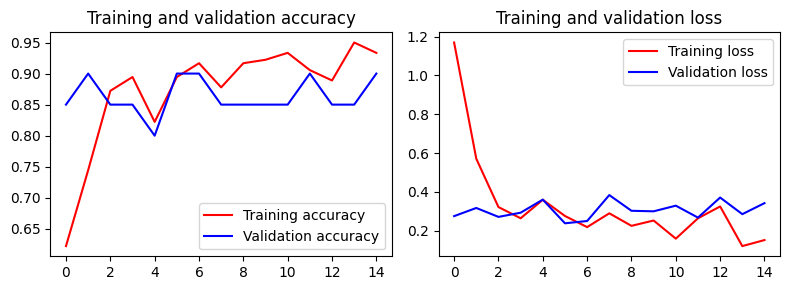

In [13]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_acc))

plt.figure(figsize=(8, 3))

plt.subplot(1,2,1)
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()